<a href="https://colab.research.google.com/github/bnelson05/Generative_Model/blob/main/GenerativeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part A: Data Loading and Splitting



# Load the tiny_shakespeare Dataset
Use the Hugging Face datasets library’s load_dataset function with "tiny_shakespeare" as the argument.

Inspect the result to confirm you have splits named “train,” “validation,” and “test.”

Notice that each of these splits contains only 1 example (a single long string).

In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset

tiny_shakespeare_ds = load_dataset("tiny_shakespeare")

for split in tiny_shakespeare_ds:
  print(f"Split type: {split}")
  example = tiny_shakespeare_ds[split][0]['text']
  print(f"Example (first 100 chars): {example[:100]}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Split type: train
Example (first 100 chars): First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
Split type: validation
Example (first 100 chars): ?

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, 
Split type: test
Example (first 100 chars): rance ta'en
As shall with either part's agreement stand?

BAPTISTA:
Not in my house, Lucentio; for, 


# Examine the Data
Retrieve the string from the "train" split. (For example, you’ll see a dictionary with a key like "text"—that’s your single item.)

Print out a small snippet (e.g., the first few hundred characters) to see how it looks. Notice it’s multiple lines of Shakespeare text, separated by \n.

In [3]:
train_string_segment = tiny_shakespeare_ds["train"][0]["text"]
print(train_string_segment[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


# Convert the Single Example into Multiple Lines
You’ll need to split the long string using the newline character ("\n").
Remove any lines that are completely empty or just whitespace.

Finally, you’ll have a list of lines—each line is a small piece of Shakespeare text.

In [4]:
split_by_lines = train_string_segment.split("\n")
# Use .strip() function for clearing whitespace: https://www.w3schools.com/python/ref_string_strip.asp
final_split_lines = [line for line in split_by_lines if line.strip()]


# def line_chunking(lines, size):
#   line_groups = []
#   for section in range(0, len(lines), size):
#     line_groups.append(" ".join(lines[section:section + size]))
#   return line_groups

# final_grouped_lines = line_chunking(final_split_lines, 5)

print("Original dataset length: ", len(train_string_segment))
print("Split on newline dataset length: ", len(final_split_lines))
# print("Grouped by chunks of 5 dataset length: ", len(final_grouped_lines))

print(final_split_lines[:5])
# print(final_grouped_lines[:5])

Original dataset length:  1003854
Split on newline dataset length:  29242
['First Citizen:', 'Before we proceed any further, hear me speak.', 'All:', 'Speak, speak.', 'First Citizen:']


# Create a Dataset of Lines
Transform that list of lines into a Hugging Face Dataset object.

This will give you a dataset with many rows (one row per line), rather than a single row with a giant string.

In [5]:
from datasets import Dataset

# Hugging Face Create a Dataset: https://huggingface.co/docs/datasets/en/create_dataset
dataset_dict = {"text": final_split_lines}
lines_dataset = Dataset.from_dict(dataset_dict)
print(lines_dataset)

Dataset({
    features: ['text'],
    num_rows: 29242
})


# Split That Dataset into Train & Validation
Use the .train_test_split method (from the datasets library) on your newly created dataset.

Choose a test size (like 0.1, or 10%). The result is a DatasetDict with a “train” split and a “test” split.

Name them train_data and val_data (since we’re treating the test split as validation).

Print out the sizes to confirm you have a healthy number of lines in each.

In [6]:
lines_dataset_split = lines_dataset.train_test_split(test_size = 0.1)

train_data = lines_dataset_split["train"]
val_data = lines_dataset_split["test"]

print(f"Length of train split: {len(train_data)}")
print(f"Length of test split: {len(val_data)}")

Length of train split: 26317
Length of test split: 2925


# Part B: Tokenization and Processing

# Load the Model & Tokenizer

**What**: We’ll use the model distilgpt2.

**Why**: A pretrained tokenizer ensures we map text to the correct input IDs for our model (basically it maps text to numbers which computers can understand).

In [7]:
from transformers import AutoTokenizer

# DistilGPT2 is a pre-trained language model
model_name = "distilgpt2"
# Tokenizer is a tool that converts text to numbers that the model can understand
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
# Pad token tells the model where a sequence ends and where padding starts
# GPT-2 doesn't have a pad token by default, so:
tokenizer.pad_token = tokenizer.eos_token

# Write a tokenize_function

**What**: A function that takes a batch of text lines, and returns their tokenized form. ML models take inputs in so-called "batches" - meaning that passing them one input at a time is wasteful, so usually multiple inputs are passed at once. When you see something like batch_size = 256, it means that the model takes in 256 inputs at the same time. Ideally of course we'd like to pass the entire dataset in a single batch but GPUs don't have enough memory to store the entire dataset so we need to pick a large enough batch size for efficiency but small enough to fit in your GPU. (if your batch size is too large for your GPU, you might get a GPU VRAM fault , think of it something like segmentation fault but for GPUs)

**Why**: Hugging Face’s .map() calls this tokenizer on each batch behind the scenes. Essentially, for a batch of sentences, the tokenizer maps them to numbers.

**Key Points**:
We do truncation=True and max_length=128 or 256 for memory efficiency.
Remove any lingering empty lines if needed.

In [8]:
# Function that takes a batch of text and converts it using the tokenizer
# Processing sentences in batches is more efficient
def tokenize_function(examples):
  return tokenizer(
    examples["text"],
    truncation=True,
    max_length=128
)

# Apply .map() to Create train_dataset & val_dataset

**What**: Convert your raw text lines into model-ready tokens.

**Why**: This is the final step before training. We remove the original “text” column, leaving only tokenized forms.

In [9]:
# .map() applies the tokenization function to the data
train_dataset = train_data.map(tokenize_function, batched=True, remove_columns=["text"])
val_dataset = val_data.map(tokenize_function, batched=True, remove_columns=["text"])

print(train_dataset[0])
print(len(train_dataset))
print(len(val_dataset))

Map:   0%|          | 0/26317 [00:00<?, ? examples/s]

Map:   0%|          | 0/2925 [00:00<?, ? examples/s]

{'input_ids': [33, 630, 258, 314, 1028, 17903, 11, 2402, 2356, 286, 1204, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
26317
2925


# Part C

# Training Arguments
Create a TrainingArguments object that specifies:

Where to save the model output (like output_dir="./distilgpt2-finetuned-shakespeare").

Number of epochs (e.g., 1–3 for quick tests; more if you want deeper fine-tuning).

Batch size (often small, like 2, if you’re on limited GPU memory).

Logging and evaluation frequency (for instance, log every 50 steps, evaluate every 100 steps).

In [14]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir="./distilgpt2-finetuned-shakespeare",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    logging_steps = 50,
    eval_steps = 200,
    report_to="none",
    eval_strategy = "steps",
    save_steps = 13000
    )

# Trainer Setup
Use the Hugging Face Trainer class and pass in:

model: a GPT-2–style model (e.g., distilgpt2) loaded from AutoModelForCausalLM.

training_args: the arguments from above.

train_dataset and eval_dataset: the tokenized datasets from Part B.

data_collator: a collator that pads data for causal language modeling (if needed).

In [15]:
from transformers import AutoModelForCausalLM, DataCollatorForLanguageModeling
model = AutoModelForCausalLM.from_pretrained("distilgpt2")
# Applies padding
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    # Treats it as casual language modeling
    mlm=False
)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    data_collator = data_collator
)

# Callbacks for Mid-Training Generation
Hugging Face supports callbacks (TrainerCallback) that trigger code at certain events.

Create a callback that, say, every 100 eval steps:

Takes a prompt (e.g., "Wherefore art thou")

Generates ~50 tokens

Prints the sample to the console/log.

This helps you see the model evolving mid-training.

In [16]:
from transformers import TrainerCallback
class MidTrainingCallback(TrainerCallback):
  def __init__(self, model, tokenizer, prompt, generation_length):
    self.model = model
    self.tokenizer = tokenizer
    self.prompt = prompt
    self.generation_length = generation_length

  def on_evaluate(self, args, state, control, model=None, **kwargs):
    if model is not None:
      model = model
    else:
      model = self.model

    # Tokenize the prompt and get both input IDs and attention mask
    inputs = self.tokenizer(self.prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)
    prompt_encode = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Set pad_token_id if it's not already defined
    if self.tokenizer.pad_token_id is None:
        self.tokenizer.pad_token_id = self.tokenizer.eos_token_id

    # Generate the output using attention mask
    output = model.generate(prompt_encode, attention_mask=attention_mask, max_length=self.generation_length, pad_token_id=self.tokenizer.pad_token_id)
    generated_text = self.tokenizer.decode(output[0], skip_special_tokens=True)

    print(f"Step Number {state.global_step}: {generated_text}")

callback = MidTrainingCallback(
    model = model,
    tokenizer = tokenizer,
    prompt = "Wherefore art thou",
    generation_length = 50
)

trainer.add_callback(callback)

# .train() Method
Call .train() on your Trainer object. You should see logs showing training loss and eval loss as the steps progress.

Keep an eye on:

Train Loss – does it steadily decrease?

Eval Loss – does it decrease as well, or start to level off/oscillate?

In [17]:
trainer.train()

Step,Training Loss,Validation Loss
200,4.653600,5.090886
400,4.520100,4.904284
600,4.455100,4.779420
800,4.454300,4.722745
1000,4.335800,4.651248
1200,4.053100,4.592902
1400,3.964000,4.582392
1600,4.156600,4.515028
1800,4.182600,4.479609
2000,4.065200,4.449106


Step Number 200: Wherefore art thou art? I am not so. But I am not so. But I am not so. But I am not so. But I am not so. But I am not so. But I am not so. But I am
Step Number 400: Wherefore art thou art, and thou art, and thou art, and thou art, and thou art, and thou art, and thou art, and thou art, and thou art, and thou art, and thou art, and thou art,
Step Number 600: Wherefore art thou hast a son, and thou hast a son, and thou hast a son, and thou hast a son, and thou hast a son, and thou hast a son, and thou hast a son, and thou hast a son,
Step Number 800: Wherefore art thou art a man, and thou art a man, and thou art a man, and thou is a man. But, if thou be a man, thou is a man. But, if thou be a man, thou is a
Step Number 1000: Wherefore art thou art a man of the world, and that thou be a man of the world, and that thou be a man of the world. But, I am not a man of the world, and I am a man of the world
Step Number 1200: Wherefore art thou art a man, a man, a man, a man, a 

TrainOutput(global_step=39477, training_loss=3.4193483647337004, metrics={'train_runtime': 2672.4502, 'train_samples_per_second': 29.543, 'train_steps_per_second': 14.772, 'total_flos': 221901161988096.0, 'train_loss': 3.4193483647337004, 'epoch': 3.0})

# Generate a Test Sample
After training, set the model to eval mode and choose a prompt (like "Thus speaks").

Use the model’s .generate(...) or a pipeline("text-generation", ...) to produce text.

Compare this generated text to the un-fine-tuned model’s output—do you see more Shakespearean style?

In [18]:
from transformers import pipeline
model.eval()
text_generator_finetuned = pipeline("text-generation", model=model, tokenizer="distilgpt2")
generated_text_finetuned = text_generator_finetuned("Thus speaks", max_length=100, num_return_sequences=1)

text_generator_original = pipeline("text-generation", model="distilgpt2", tokenizer="distilgpt2")
generated_text_original = text_generator_original("Thus speaks", max_length=100, num_return_sequences=1)


print("Generated text using the fine-tuned model:")
print(generated_text_finetuned[0]['generated_text'])
# Thus speaks the time. Is't it not so?--Well--there is in thy body.--forswear it;--forswear it--forswear!--forswear it;--for thee!--forswear.
# --for thy hate, boy. For this, daughter, I. For thy wife! I. For my love, my hand, my hand: for thy love, my hand, my life, my hand: there's no more of them
print("")
print("Generated text using the original model:")
print(generated_text_original[0]['generated_text'])
# Thus speaks to me the spirit, which can be found throughout the heavens, which cannot be removed by the law, which also cannot be removed by all men…
# For the same reason, the Almighty, being the Father of all things, cannot be seen by himself on account of me [is] an angel; he can see not a man's soul;
# or a spirit, but his Spirit, even on occasion, in his eyes, with him, in his eyes: as is understood by the Lord

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated text using the fine-tuned model:
Thus speaks, that is, by my faith, and partly I am. Therefore, my counsel. Farewell, good Catesby. Farewell, you. Farewell, gentle-giver. Farewell. Farewell. Farewell. I say, friends,--beseeming. Farewell, good Catesby. Farewell. Farewell. Farewell, Catesby. Farewell, gentlemen. Farewell; good day. Farewell, masters, let us depart

Generated text using the original model:
Thus speaks a strong message to all.





It's the truth. If we are to accept this, then let us reject it. Now, let us accept it. We must recognize the reality of one's experience that we have a moral duty to behave in certain ways and that we are obliged to do so. If we do not, we cannot accept it without recognizing it as some false assumption. If we accept, then let us accept it.
Why would we let


# Reflection
The training loss mostly decreases, but occassionally oscillates, and the evaluation loss steadily decreases for the most part. The text generation using the fine-tuned model looks for Shakespeare-like compared to the original text generation model.

# Part D: Advanced Features

# Custom Metrics (Perplexity)

Write a compute_metrics function for your Trainer that calculates perplexity.

Perplexity is exp(loss) for language models; see if it aligns with your observed evaluation loss.

Confirm in the logs that your metric is appearing each time you evaluate.

In [20]:
import math

def compute_metrics(trainer):
    eval_results = trainer.evaluate()
    eval_loss = eval_results.get("eval_loss")
    print(f"Eval Loss: {eval_loss}")

    perplexity = math.exp(eval_loss)
    print(f"Perplexity: {perplexity}")
    return perplexity

compute_metrics(trainer)

Step Number 39477: Wherefore art thou dead? and what is thy name? and what is thy name? and what is thy name? and what is thy name? and what is thy name? and what is thy name? and what is thy name? and what
Eval Loss: 4.086084842681885
Perplexity: 59.506457893184546


59.506457893184546

# Visualizing Loss Curves
After training, check trainer.state.log_history or your training logs.

Plot:

Training loss vs. steps

Validation loss vs. steps

Observe if the validation loss mirrors training loss (good) or starts diverging (potential overfitting).


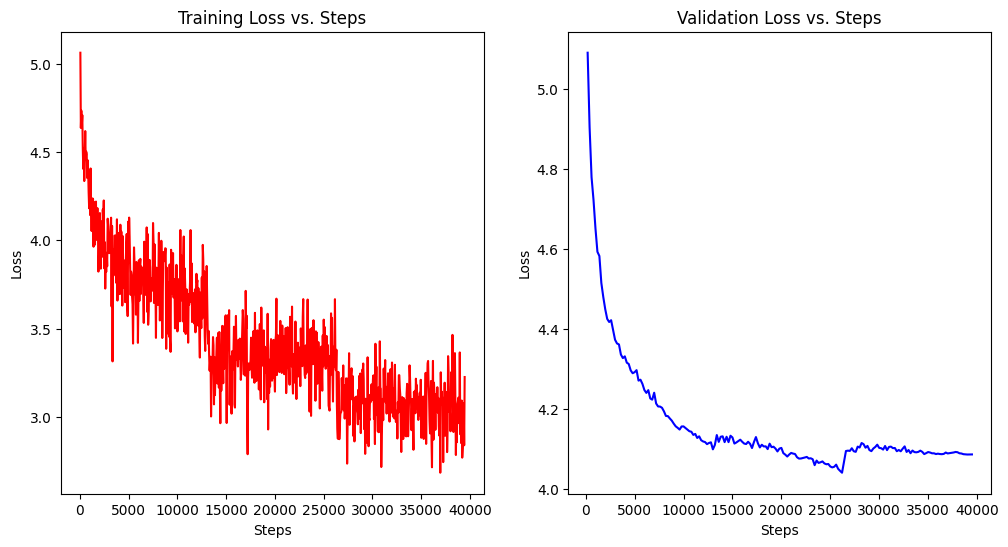

In [21]:
import matplotlib.pyplot as plt

train_loss = []
train_steps = []
eval_loss = []
eval_steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_steps.append(log["step"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        eval_steps.append(log["step"])
        eval_loss.append(log["eval_loss"])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label="Training Loss", color="red")
plt.title("Training Loss vs. Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_loss, label="Validation Loss", color="blue")
plt.title("Validation Loss vs. Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")

plt.show()